In [1]:
import pandas as pd
import pickle
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_decomposition import CCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
#from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
#import seaborn as sns

from scipy.cluster.hierarchy import dendrogram, linkage

from moments_engr import *

In [2]:
path1 = 'C:\\Users\\kdmen\\Box\\Meta_Gesture_2024\\saved_datasets\\filtered_datasets\\$BStand_EMG_df.pkl'

with open(path1, 'rb') as file:
    raw_userdef_data_df = pickle.load(file)  # (204800, 19)
 

In [3]:
print(raw_userdef_data_df.shape)
raw_userdef_data_df.head()

(204800, 19)


,Participant,Gesture_ID,Gesture_Num,EMG1,EMG2,EMG3,EMG4,EMG5,EMG6,EMG7,EMG8,EMG9,EMG10,EMG11,EMG12,EMG13,EMG14,EMG15,EMG16
0,P102,pan,1,-0.362743,-0.801651,-0.383077,-0.195299,-0.203047,-0.464472,-0.276292,-0.026736,-0.873870,-1.036152,-0.580930,-0.719494,-0.502255,-1.750091,-0.127847,-0.094192
1,P102,pan,1,-0.351553,-0.775334,-0.382545,-0.154773,-0.131977,-0.295204,-0.125822,0.089679,-0.816215,-2.082635,-0.006283,-0.139439,-0.367764,-0.208084,-0.111811,-0.039009
2,P102,pan,1,-0.380825,-0.762588,-0.398388,-0.085411,0.017528,-0.205675,-0.068451,0.117076,-0.668221,-3.403064,-0.526030,-0.478294,-0.300443,0.203266,0.113300,0.004728
3,P102,pan,1,-0.366795,-0.765464,-0.374423,-0.073225,0.183172,0.009277,-0.058907,0.080977,-0.424416,-3.709413,-0.570894,-0.775155,-0.144710,-0.619539,0.146499,0.199975
4,P102,pan,1,-0.245578,-0.761283,-0.303976,-0.081947,0.224996,0.103319,-0.003929,0.041526,-0.016530,-4.075150,-0.127710,2.682791,-0.141750,-0.208404,-0.035642,0.172662


 As a preliminary step, we can simulate each user training a gesture classification model using solely their own dataset. We can then execute a pairwise comparison, where we test each user’s model and every other user’s dataset, and report the score. At this point, we can begin a agglomerative clustering procedure, by either clustering the two users with the highest corresponding scores, or by clustering all users that achieved above some minimum cross-subject classification accuracy. Then, we can repeat this procedure on the newly formed clusters, this time training a single model over all the data in the given cluster. By repeating this process until only one model remains, we can generate a dendrogram showing which users are best clustered in order to train cluster-level models. One issue with this approach is that as the clusters grow, the training sets will grow in tandem. To a limited extent, this can be offset by limiting all dataset sizes to the size of single user’s dataset and having the cluster model train on a random sample of gestures. An alternative approach would be to enforce all users into clusters of the same size each round, so that all clusters have the same dataset size, although this would artificially create many clusters. However, we also expect to have the opposite problem, as in myprevious works I have shown that cross-subject models typically perform poorly in general for these types of tasks, e.g. that training over multiple users will likely only grant modest improvements in performance, if any (especially if fixing the training dataset size). The goal of this procedure is to yield clusters for which the internal cluster model performs better than any of the intra-subject models within the cluster. Even if the internal cluster model does not outperform all intra-subject models, as long as it reduces the calibration / number of samples required from a novel user, this is still a success.

In [4]:
# STEP 1: Train a classification model on every single individual user

userdef_df = raw_userdef_data_df.groupby(['Participant', 'Gesture_ID', 'Gesture_Num']).apply(create_feature_vectors)
#output is df with particpant, gesture_ID, gesture_num and feature (holds 80 len vector)
userdef_df = userdef_df.reset_index(drop=True)

#convert Gesture_ID to numerical with new Gesture_Encoded column
label_encoder = LabelEncoder()
userdef_df['Gesture_Encoded'] = label_encoder.fit_transform(userdef_df['Gesture_ID'])

label_encoder2 = LabelEncoder()
userdef_df['Cluster_ID'] = label_encoder2.fit_transform(userdef_df['Participant'])

print(userdef_df.shape)
userdef_df.head()

(3200, 6)


,Participant,Gesture_ID,Gesture_Num,feature,Gesture_Encoded,Cluster_ID
0,P004,close,1,"[[6.079045311063784], [-7.551458873254243], [-...",0,0
1,P004,close,10,"[[5.994789910363704], [-7.978871468164499], [-...",0,0
2,P004,close,2,"[[6.010193380499154], [-7.7063875553339], [-20...",0,0
3,P004,close,3,"[[5.8212078257286874], [-7.463908156909893], [...",0,0
4,P004,close,4,"[[5.974675085061773], [-7.945111601415482], [-...",0,0


In [5]:
def train_cluster_model(userdef_df, model, cluster_column='Cluster_ID', feature_column='feature', target_column='Gesture_Encoded'):
    """
    Train a specific model for each cluster in the dataset.

    Parameters:
    - userdef_df (DataFrame): The input dataframe with cluster, feature, and target data.
    - model (str or sklearn model object): The model to train. If string, it must be one of:
      ['LogisticRegression', 'SVC', 'RandomForest', 'GradientBoosting', 'KNN', 'XGBoost'].
    - cluster_column (str): Column name representing the cluster IDs.
    - feature_column (str): Column name containing feature arrays.
    - target_column (str): Column name for target labels.

    Returns:
    - model_list (list): A list of trained models, one per cluster.
    """
    
    # Mapping model names to objects
    model_map = {
        'LogisticRegression': LogisticRegression(random_state=42),
        'SVC': SVC(kernel='rbf', random_state=42),
        'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
        'GradientBoosting': GradientBoostingClassifier(random_state=42),
        'KNN': KNeighborsClassifier(n_neighbors=5),
        # 'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
    }
    
    # Get the model object if a string is provided
    if isinstance(model, str):
        if model not in model_map:
            raise ValueError(f"Unsupported model: {model}. Choose from {list(model_map.keys())}.")
        base_model = model_map[model]
    else:
        base_model = model

    model_list = []
    cluster_ids = userdef_df[cluster_column].unique()

    for clus_idx, cluster in enumerate(cluster_ids):
        # Get data for the current cluster
        clus_trainset = userdef_df[userdef_df[cluster_column] == cluster]

        # Split into training and testing data
        X_train, _, y_train, _ = train_test_split(
            np.array(clus_trainset[feature_column]), 
            np.array(clus_trainset[target_column]), 
            test_size=0.3, 
            random_state=42, 
            stratify=np.array(clus_trainset[target_column]))
        # Flatten the feature arrays if necessary
        X_train = np.array([x.flatten() for x in X_train])

        # Create a new model instance for this cluster
        model = base_model.__class__(**base_model.get_params())
        model.fit(X_train, y_train)
        model_list.append(model)

    return model_list


In [6]:
def test_models_on_clusters(userdef_df, trained_clus_models_lst, cluster_column='Cluster_ID', feature_column='feature', target_column='Gesture_Encoded'):
    """
    Test trained models for each cluster on every other cluster's data.

    Parameters:
    - userdef_df (DataFrame): The input dataframe with cluster, feature, and target data.
    - trained_clus_models_lst (list): A list of trained models corresponding to each cluster.
    - cluster_column (str): Column name representing the cluster IDs.
    - feature_column (str): Column name containing feature arrays.
    - target_column (str): Column name for target labels.

    Returns:
    - accuracy_matrices (dict): A dictionary where keys are model indices, and values are accuracy matrices.
    """
    cluster_ids = userdef_df[cluster_column].unique()
    num_clusters = len(cluster_ids)

    # Initialize accuracy matrices for each model
    #accuracy_matrices = {i: np.zeros((num_clusters, num_clusters)) for i in range(len(trained_clus_models_lst))}
    acc_matrix = np.zeros((num_clusters, num_clusters))
    
    for clus_idx, cluster in enumerate(cluster_ids):
        #print(f"Testing models for cluster {clus_idx + 1} of {num_clusters} (ID: {cluster})")

        # Select this cluster's model to test on every other cluster
        model = trained_clus_models_lst[clus_idx]

        for clus_idx2, cluster2 in enumerate(cluster_ids):
            # Extract test data for the second cluster
            clus_testset = userdef_df[userdef_df[cluster_column] == cluster2]
            _, X_test, _, y_test = train_test_split(
                np.array(clus_testset[feature_column]),
                np.array(clus_testset[target_column]),
                test_size=0.3,
                random_state=42,
                stratify=np.array(clus_testset[target_column])
            )
            X_test = np.array([x.flatten() for x in X_test])

            # Test given model on the new cluster's test set and store accuracy
            acc_matrix[clus_idx, clus_idx2] = accuracy_score(y_test, model.predict(X_test))
            
            #acc = accuracy_score(y_test, model.predict(X_test))
            #print(f"{clus_idx, clus_idx2}: {acc*100:.2f}%")
            # clus_idx, clus_idx2 works as expected, but accs dont change across different cluster models being used...

    return acc_matrix


In [7]:
# STEP 3: Combine the datasets of the two closest users (best pairwise performance --> is it two-way??)


In [8]:
def visual_test_acc_analysis(test_acc_matrix, plot_heatmaps=True, heatmap_mask_min_val=0.2, print_top_n=True, n=5):

    if plot_heatmaps:
        masked_array = np.ma.masked_where(test_acc_matrix < heatmap_mask_min_val, test_acc_matrix)
        # Create a figure with two subplots
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns
        # Plot the original matrix
        axes[0].imshow(svc_clus_sym_matrix, cmap='viridis', interpolation='nearest')
        cbar1 = fig.colorbar(axes[0].imshow(test_acc_matrix, cmap='viridis', interpolation='nearest'), ax=axes[0])
        cbar1.set_label('Pairwise Test Accuracy')
        # Plot the masked matrix
        im = axes[1].imshow(masked_array, cmap='viridis', interpolation='nearest')
        cbar2 = fig.colorbar(im, ax=axes[1])
        cbar2.set_label('Pairwise Test Accuracy')
        # Adjust layout for clarity
        plt.tight_layout()
        plt.show()

    if print_top_n:
        # Mask the diagonal by setting it to a very low value (or using masking)
        masked_array = test_acc_matrix.copy()
        np.fill_diagonal(masked_array, 0.0)  # Set diagonal values to 0.0
        # Flatten the array and get the indices of the largest 5 values
        flat_indices = np.argpartition(masked_array.flatten(), -5)[-n:]
        top_values_indices = flat_indices[np.argsort(masked_array.flatten()[flat_indices])[::-1]]
        # Convert flat indices back to 2D indices
        row_col_indices = np.unravel_index(top_values_indices, masked_array.shape)
        top_values = svc_clus_sym_matrix[row_col_indices]
        # Print the results
        print(f"Top {n} values (excluding diagonal):")
        for value, (row, col) in zip(top_values, zip(*row_col_indices)):
            print(f"Value: {value:.4f} at position ({row}, {col})")
            

def extract_top_n_highest_pairs(test_acc_matrix, n=1, print_top_n=False):
    # NOT BEING USED RN --> Kept merging with test pair acc of 0.0... idk why
    
    # Mask the diagonal by setting it to a very low value (or using masking)
    masked_array = test_acc_matrix.copy()
    np.fill_diagonal(masked_array, 0.0)  # Set diagonal values to 0.0
    # Flatten the array and get the indices of the largest n values
    ## ^ BREAKS WHEN the array only has 2 clusters left!
    flat_indices = np.argpartition(masked_array.flatten(), -5)[-n:]
    top_values_indices = flat_indices[np.argsort(masked_array.flatten()[flat_indices])[::-1]]
    # Convert flat indices back to 2D indices
    row_col_indices = np.unravel_index(top_values_indices, masked_array.shape)
    top_values = test_acc_matrix[row_col_indices]
    if print_top_n:
        print(f"Top {n} values (excluding diagonal):")
        for value, (row, col) in zip(top_values, zip(*row_col_indices)):
            print(f"Value: {value:.4f} at position ({row}, {col})")
            
    return top_values, row_col_indices

In [9]:
# STEP 4: Repeat STEPS 1-3 until only 1 cluster remains

In [10]:
# Data structures for logging cluster merging procedure
merge_log = []  # List of tuples: [(cluster1, cluster2, distance, new_cluster), ...]
unique_clusters_log = []  # List of lists: [list of unique clusters at each step]

# Dictionary to store self-performance over iterations
cluster_performance = {}
# Simulate cluster merging and model performance tracking
iterations = 0

while len(userdef_df['Cluster_ID'].unique()) > 1:
    print(len(userdef_df['Cluster_ID'].unique()))
    
    # Log the current state of clusters
    unique_clusters_log.append(sorted(userdef_df['Cluster_ID'].unique()))
    # Map indices to cluster IDs
    ## TODO: I am not sure if this should be sorted or not...
    current_cluster_ids = sorted(userdef_df['Cluster_ID'].unique())
    
    # Train models and test similarities
    svc_clus_model_lst = train_cluster_model(userdef_df, "SVC")
    sym_acc_arr = test_models_on_clusters(userdef_df, svc_clus_model_lst)
    if len(userdef_df['Cluster_ID'].unique())==2:
        print(sym_acc_arr)
        
    # Update the cluster performance log with diagonal values
    diagonal_values = np.diag(sym_acc_arr)  # sym_acc_arr is the similarity matrix
    # Update performance logs
    for idx, cluster_id in enumerate(current_cluster_ids):
        if cluster_id not in cluster_performance:
            cluster_performance[cluster_id] = []  # Initialize list
        cluster_performance[cluster_id].append((iterations, diagonal_values[idx]))
        
    #print(f"max pairwise acc {np.max(sym_acc_arr)} @ (flattened?) index {np.argmax(sym_acc_arr)}")
    # Find the most similar clusters to merge
    # extract_top_n_highest_pairs returning 0.0... pretty sure that is wrong
    #top_values, row_col_indices = extract_top_n_highest_pairs(sym_acc_arr)
    #row_idx_to_merge = row_col_indices[0][0]
    #col_idx_to_merge = row_col_indices[1][0]
    #similarity_score = top_values[0]
    # Simpler approach:
    masked_diag_array = sym_acc_arr.copy()
    np.fill_diagonal(masked_diag_array, 0.0)
    similarity_score = np.max(masked_diag_array)
    max_index = np.unravel_index(np.argmax(masked_diag_array), masked_diag_array.shape)
    row_idx_to_merge = max_index[0]
    col_idx_to_merge = max_index[1]
    # Get actual cluster IDs to merge
    row_cluster_to_merge = current_cluster_ids[row_idx_to_merge]
    col_cluster_to_merge = current_cluster_ids[col_idx_to_merge]
    
    # Create a new cluster ID for the merged cluster
    new_cluster_id = max(current_cluster_ids) + 1
    print(f"MERGE: {row_cluster_to_merge, col_cluster_to_merge} @ {similarity_score*100:.2f}. New cluster: {new_cluster_id}")
    print()
    # Log the merge
    merge_log.append((row_cluster_to_merge, col_cluster_to_merge, similarity_score, new_cluster_id))
    # Update the DataFrame with the new merged cluster
    userdef_df.loc[userdef_df['Cluster_ID'].isin([row_cluster_to_merge, col_cluster_to_merge]), 'Cluster_ID'] = new_cluster_id

    # Remove merged clusters from tracking
    cluster_performance[row_cluster_to_merge].append((iterations, None))  # Mark end
    cluster_performance[col_cluster_to_merge].append((iterations, None))  # Mark end
    iterations += 1

32
MERGE: (0, 14) @ 40.00. New cluster: 32

31
MERGE: (19, 8) @ 36.67. New cluster: 33

30
MERGE: (21, 9) @ 36.67. New cluster: 34

29
MERGE: (23, 10) @ 36.67. New cluster: 35

28
MERGE: (25, 11) @ 36.67. New cluster: 36

27
MERGE: (27, 12) @ 36.67. New cluster: 37

26
MERGE: (29, 13) @ 36.67. New cluster: 38

25
MERGE: (31, 15) @ 36.67. New cluster: 39

24
MERGE: (33, 16) @ 36.67. New cluster: 40

23
MERGE: (34, 17) @ 36.67. New cluster: 41

22
MERGE: (35, 18) @ 36.67. New cluster: 42

21
MERGE: (28, 2) @ 30.00. New cluster: 43

20
MERGE: (32, 3) @ 30.00. New cluster: 44

19
MERGE: (36, 4) @ 30.00. New cluster: 45

18
MERGE: (6, 5) @ 26.67. New cluster: 46

17
MERGE: (24, 43) @ 30.00. New cluster: 47

16
MERGE: (26, 45) @ 30.00. New cluster: 48

15
MERGE: (22, 7) @ 33.33. New cluster: 49

14
MERGE: (37, 20) @ 33.33. New cluster: 50

13
MERGE: (39, 30) @ 33.33. New cluster: 51

12
MERGE: (41, 38) @ 33.33. New cluster: 52

11
MERGE: (44, 40) @ 33.33. New cluster: 53

10
MERGE: (47, 42) 

In [11]:
# Not useful... merged at the same heights mostly...

# Convert merge_log to a linkage matrix
#linkage_matrix = []
#cluster_sizes = {cluster: 1 for cluster in unique_clusters_log[0]}  # Initialize cluster sizes
#
#for cluster1, cluster2, distance, new_cluster in merge_log:
#    size1 = cluster_sizes.pop(cluster1)
#    size2 = cluster_sizes.pop(cluster2)
#    cluster_sizes[new_cluster] = size1 + size2
#    linkage_matrix.append([cluster1, cluster2, distance, size1 + size2])
#
#linkage_matrix = np.array(linkage_matrix)
#
# Plot the dendrogram
#plt.figure(figsize=(10, 6))
#dendrogram(linkage_matrix, labels=unique_clusters_log[0])
#plt.title("Dendrogram of Cluster Merging")
#plt.xlabel("Cluster ID")
#plt.ylabel("Similarity Score (1 - Distance)")
#plt.show()


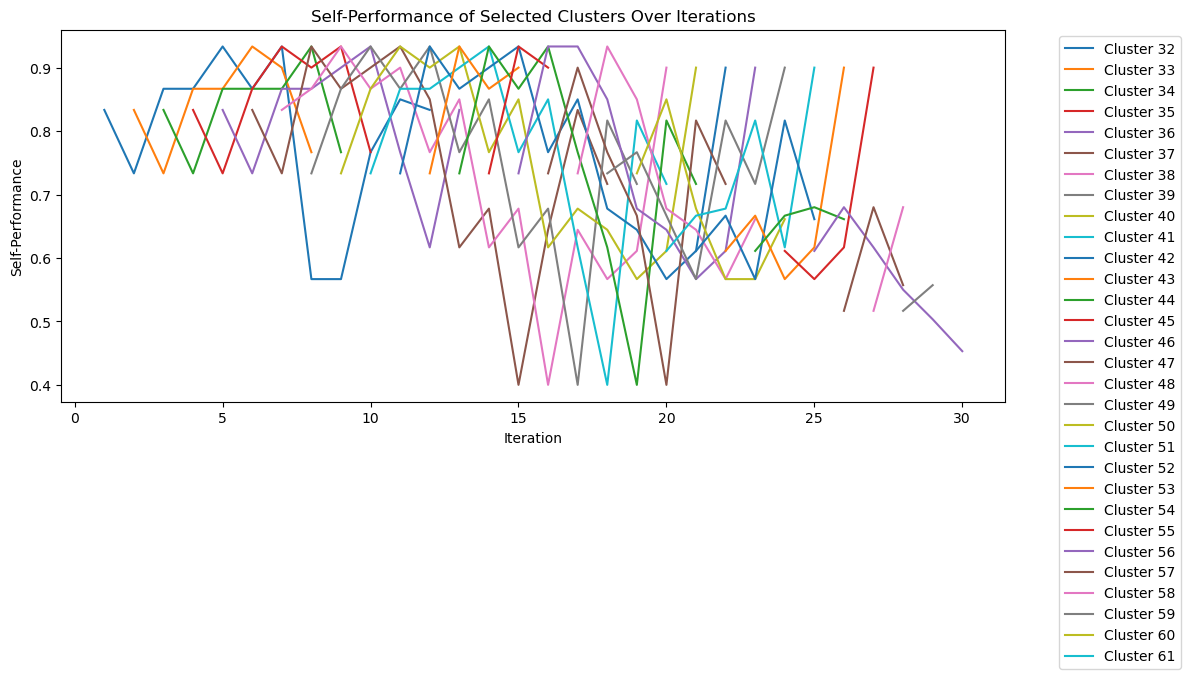

In [19]:
# Visualization
plt.figure(figsize=(12, 6))

for cluster_id in cluster_performance:
    # Extract valid iterations and performance
    data = cluster_performance[cluster_id]
    valid_iterations = [it for it, perf in data if perf is not None]
    valid_performance = [perf for it, perf in data if perf is not None]
    if valid_iterations[0]==0:
        continue
    #print(valid_iterations)
    #print(valid_performance)
    #print()
    plt.plot(valid_iterations, valid_performance, label=f"Cluster {cluster_id}")

plt.xlabel("Iteration")
plt.ylabel("Intra-Cluster Test Accuracy")
plt.title("Intra-Cluster Test Accuracy: Merged Clusters Only")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

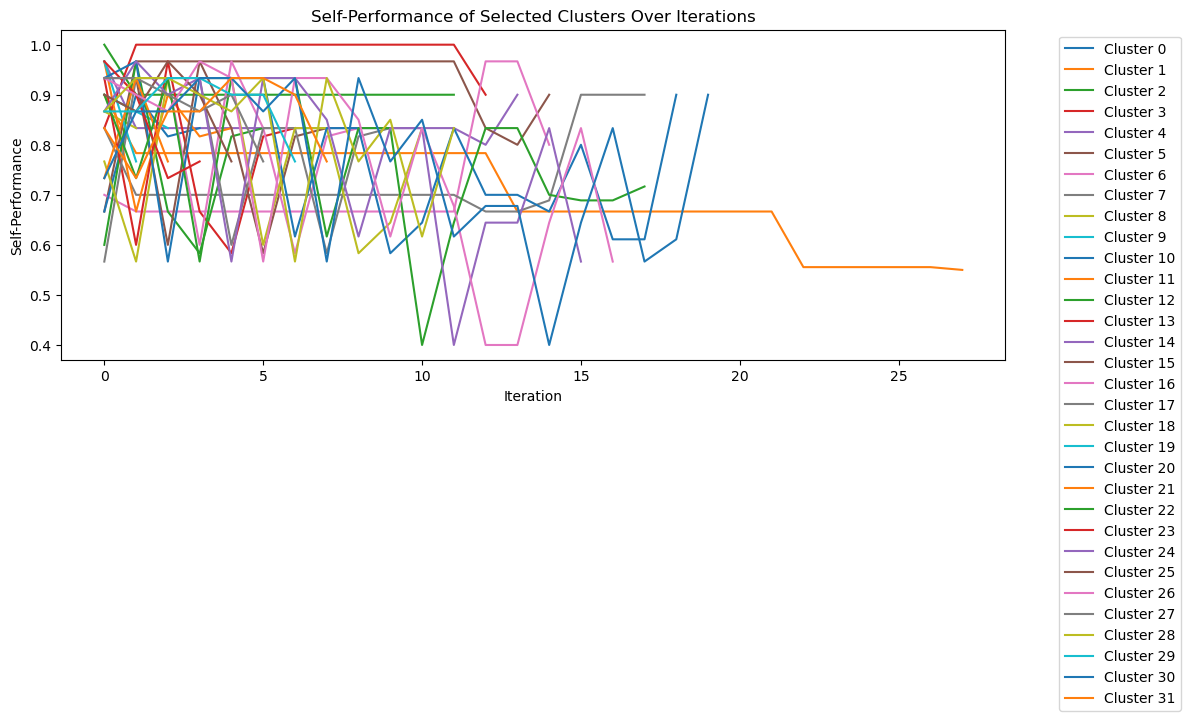

In [20]:
# Visualization
plt.figure(figsize=(12, 6))

for cluster_id in cluster_performance:
    # Extract valid iterations and performance
    data = cluster_performance[cluster_id]
    valid_iterations = [it for it, perf in data if perf is not None]
    valid_performance = [perf for it, perf in data if perf is not None]
    if valid_iterations[0]!=0:
        continue
    #print(valid_iterations)
    #print(valid_performance)
    #print()
    plt.plot(valid_iterations, valid_performance, label=f"Cluster {cluster_id}")

plt.xlabel("Iteration")
plt.ylabel("Intra-Cluster Test Accuracy")
plt.title("Intra-Cluster Test Accuracy: Original Clusters Only")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

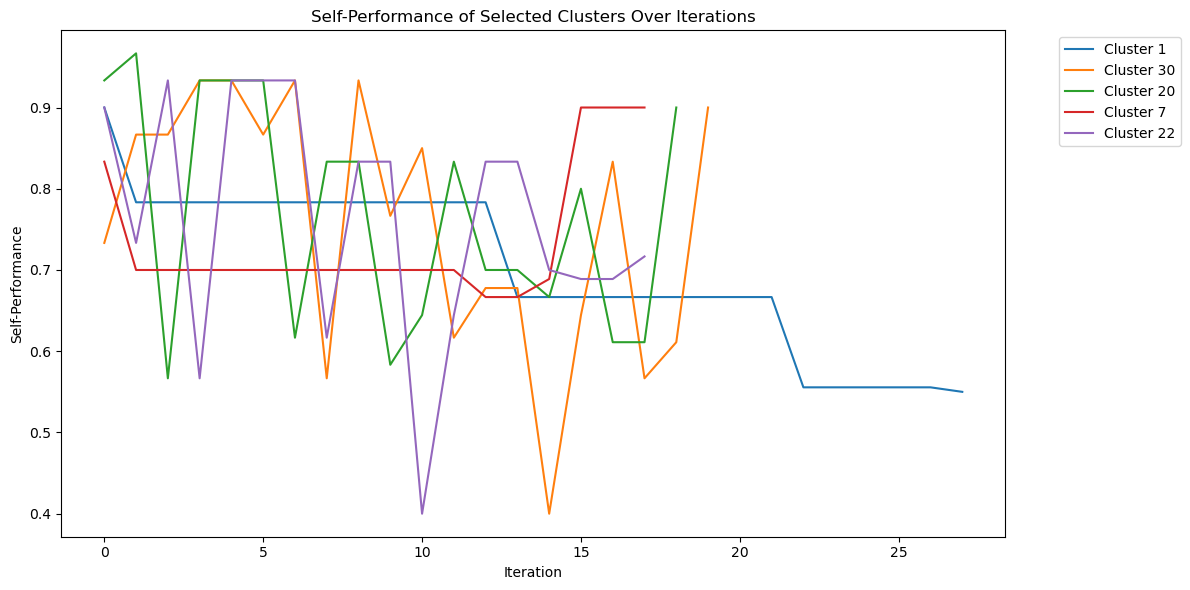

In [24]:
# Visualization
plt.figure(figsize=(12, 6))

# Reduce number of lines (e.g., top 10 longest-lived clusters)
longest_clusters = sorted(cluster_performance.keys(), key=lambda k: len(cluster_performance[k]), reverse=True)[:5]

for cluster_id in longest_clusters:
    # Extract valid iterations and performance
    data = cluster_performance[cluster_id]
    valid_iterations = [it for it, perf in data if perf is not None]
    valid_performance = [perf for it, perf in data if perf is not None]
    plt.plot(valid_iterations, valid_performance, label=f"Cluster {cluster_id}")

plt.xlabel("Iteration")
plt.ylabel("Intra-Cluster Test Accuracy")
plt.title("Intra-Cluster Test Accuracy: 5 Longest-Lasting Clusters")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()